In [3]:
import os, sys
from pathlib import Path
script_dir = Path(os.path.dirname(os.path.abspath('')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
print(module_dir)

# import the rest of the modules
# %matplotlib nbagg
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import arch
import time  
import sim
import warnings, matplotlib
DTYPE = 'float32'
warnings.filterwarnings('ignore')
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

/Users/pman0581/Documents/GitHub/fp-solvers


In [2]:
# define drifts and diffusions
def mu1(X):
    x, y = tf.split(X, 2, axis=-1)
    z = -4. * (x*x + y*y - 1.0)
    return tf.concat([x*z, y*z], axis=-1)

def mu2(X):
    x0, x1, x2, x3, x4, x5, x6, x7, x8, x9 = tf.split(X, 10, axis=-1)
    z0 = -4. * (x0*x0 + x1*x1 - 1.)
    z1 = -4. * (x2*x2 + x3*x3 - 1.)
    z2 = -4. * (x4*x4 + x5*x5 - 1.)
    z3 = -4. * (x6*x6 + x7*x7 - 1.)
    z4 = -4. * (x8*x8 + x9*x9 - 1.)
    return tf.concat([x0*z0, x1*z0, x2*z1, x3*z1, x4*z2, x5*z2, x6*z3, x7*z3, x8*z4, x9*z4], axis=-1)

def mu3(X, alpha=10., beta=8/3., rho=28.):
    x, y, z = tf.split(X, 3, axis=-1)
    p = alpha * (y - x) 
    q = x * (rho - z) - y 
    r = x * y - beta * z
    return tf.concat([p, q, r], axis=-1)

def mu4(X, b=0.2):
    x, y, z = tf.split(X, 3, axis=-1)
    p = tf.sin(y) - b*x 
    q = tf.sin(z) - b*y 
    r = tf.sin(x) - b*z
    return tf.concat([p, q, r], axis=-1)

mus = [mu1, mu2, mu3, mu4]
root2 = np.sqrt(2., dtype=DTYPE)
sigmas = [root2, root2, 10., root2]

In [5]:
# load solutions
sf1 = '../circle-fp/data/2D'
sf2 = '../circle-fp/data/10D'
sf3 = '../non-grad3D/data/L63/1M'
sf4 = '../non-grad3D/data/Thomas/400k'

sfs = [sf1, sf2, sf3, sf4]

tag1 = 'circle2D'
tag2 = 'circle10D'
tag3 = 'L63'
tag4 = 'Thomas'

tags = [tag1, tag2, tag3, tag4]
labels = ['ring(2D)', 'ring(10D)', tag3, tag4]

nn1= arch.LSTMForgetNet(50, 3, tf.float32, name=tag1)
nn1.load_weights('{}/{}'.format(sf1, nn1.name)).expect_partial()
nn2= arch.LSTMForgetNet(50, 3, tf.float32, name=tag2)
nn2.load_weights('{}/{}'.format(sf2, nn2.name)).expect_partial()
nn3= arch.LSTMForgetNet(50, 3, tf.float32, name=tag3)
nn3.load_weights('{}/{}'.format(sf3, nn3.name)).expect_partial()
nn4= arch.LSTMForgetNet(50, 3, tf.float32, name=tag4)
nn4.load_weights('{}/{}'.format(sf4, nn4.name)).expect_partial()

nns = [None, None, nn3, nn4]

2023-12-12 20:52:33.099930: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-12 20:52:33.100002: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-12 20:52:33.100020: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-12 20:52:33.100432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-12 20:52:33.100780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# define domains
sd1 = [[-1.5]*2, [1.5]*2]
ed1 = [[-3.]*2, [3.]*2]
sd2 = [[-1.5]*10, [1.5]*10]
ed2 = [[-3.]*10, [3.]*10]
sd3 = [[-10., -15., 7.], [10., 15., 28.]]
ed3 = [[-30., -40., 0.], [30., 40., 70.]]
sd4 = [[-8.]*3, [8.]*3]
ed4 = [[-10.]*3, [10.]*3]

sds = [sd1, sd2, sd3, sd4]
eds = [ed1, ed2, ed3, ed4]

In [25]:
# calculate exit probabilities
max_comp = int(1e6)
num = int(1e5) 
dt = 0.01 
n_steps = 200
idx = [2]

for i in idx:
    exit = sim.Exit(mus[i], sigmas[i], sds[i], eds[i], sfs[i], tags[i], DTYPE, max_comp)
    exit.generate_trajectories_2(n_pts=1000, n_reps=100, n_steps=n_steps, dt=dt, net=nns[i])
    exit.calculate_max_probability()

Time taken by generate_trajectories_2 is 36.52295708656311 seconds
Time taken by calculate_max_probability is 7.270456075668335 seconds


In [8]:
# calculate exit probabilities
max_comp = int(1e6)
num = int(1e5) 
dt = 0.01 
n_steps = 50
idx = [0, 2, 3]


# plot exit probabilities
# set up plotting parameters
scale = -4
xlabel_size = ylabel_size = 15 + scale
tick_size = 10 + scale
legend_size = 15 + scale
title_size = 15 + scale
cbar_tick_size = 10 + scale
line_color = "darkgrey"
line_styles = ["solid"]*4#, "-", "--", "-."]

# define subplots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# write titles and labels
ax.set_title(r'$$', fontsize=title_size)
ax.set_xlabel(r'time ($T$)', fontsize=xlabel_size)
ax.set_ylabel(r'$\inf\limits_{\mathbf x\in \mathcal D}P(X_t\in\mathcal D^+\;\forall\, t\in[0, T]|X_0=\mathbf x)$', fontsize=ylabel_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_size)
t = np.linspace(0., n_steps*dt, num=n_steps+1, endpoint=True)

# create inset
ax_inset = ax.inset_axes([0.45, 0.2, 0.5, 0.5])

for i in idx:
    p = np.genfromtxt('{}/{}_io_prob_all_avg.csv'.format(sfs[i], tags[i]))
    ax.plot(t, p[:len(t)], linestyle=line_styles[i], lw=1.)
    # ax_inset.plot(t[:10], p[:10], linestyle=line_styles[i])
    


    
ax.legend(fontsize=legend_size)
plt.savefig('../plots/exit.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RuntimeError: latex was not able to process the following string:
b'$$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpjh65kvbc 3d869b5d0ec0d00ff848b4acdc15c49d.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./3d869b5d0ec0d00ff848b4acdc15c49d.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2023/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsfonts/amsfonts.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 3d869b5d0ec0d00ff848b4acdc15c49d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
l.29 {\sffamily $$}
                   %
No pages of output.
Transcript written on tmpjh65kvbc/3d869b5d0ec0d00ff848b4acdc15c49d.log.




Error in callback <function _draw_all_if_interactive at 0x16a508ea0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'$$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpndsuysqy 3d869b5d0ec0d00ff848b4acdc15c49d.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./3d869b5d0ec0d00ff848b4acdc15c49d.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2023/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsfonts/amsfonts.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 3d869b5d0ec0d00ff848b4acdc15c49d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
l.29 {\sffamily $$}
                   %
No pages of output.
Transcript written on tmpndsuysqy/3d869b5d0ec0d00ff848b4acdc15c49d.log.




RuntimeError: latex was not able to process the following string:
b'$$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp9pgnzxgr 3d869b5d0ec0d00ff848b4acdc15c49d.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./3d869b5d0ec0d00ff848b4acdc15c49d.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2023/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsfonts/amsfonts.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 3d869b5d0ec0d00ff848b4acdc15c49d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
l.29 {\sffamily $$}
                   %
No pages of output.
Transcript written on tmp9pgnzxgr/3d869b5d0ec0d00ff848b4acdc15c49d.log.




<Figure size 500x500 with 1 Axes>

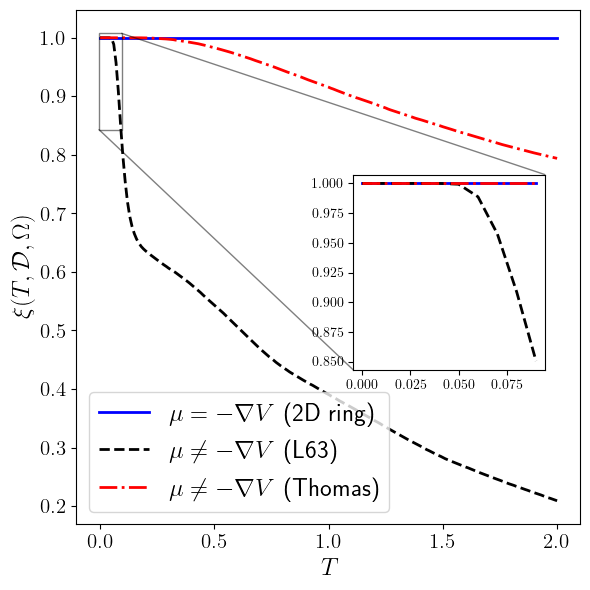

In [56]:
# calculate exit probabilities
max_comp = int(1e6)
num = int(1e5) 
dt = 0.01 
n_steps = 200
idx = [0, 2, 3]

scale = -5
xlabel_size = ylabel_size = 15 + scale
tick_size = 10 + scale
legend_size = 15 + scale
title_size = 15 + scale
cbar_tick_size = 10 + scale
line_color = "darkgrey"
line_styles = ["solid", "-", "--", "dashdot"]

# define subplots
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# write titles and labels
# ax.set_title(r'$$', fontsize=title_size)
ax.set_xlabel(r'$T$', fontsize=xlabel_size+8)
ax.set_ylabel(r'$\xi(T, \mathcal D, \Omega)$',\
              fontsize=ylabel_size+8)
ax.tick_params(axis='both', which='major', labelsize=tick_size+10)
ax.tick_params(axis='both', which='minor', labelsize=tick_size+10)
t = np.linspace(0., n_steps*dt, num=n_steps+1, endpoint=True)
ax_inset = ax.inset_axes([0.55, 0.3, 0.38, 0.38])
# create inset
# ax_inset = ax.inset_axes([0.45, 0.2, 0.5, 0.5])

labels = {0:r'$\mu=-\nabla V$ (2D ring)', 2:r'$\mu\neq-\nabla V$ (L63)', 3:r'$\mu\neq-\nabla V$ (Thomas)'}
colors = {0:'blue', 2:'black', 3:'red'}
for i in [0, 2, 3]:
    p = np.genfromtxt('{}/{}_io_prob_all_avg.csv'.format(sfs[i], tags[i]))
    ax.plot(t, p[:len(t)], label=labels[i], linestyle=line_styles[i], lw=2., c=colors[i])
    ax_inset.plot(t[:10], p[:10], linestyle=line_styles[i], lw=2., c=colors[i])
#     ax_inset.plot(t[:10], p[:10], linestyle=line_styles[i])
    




# ax.tick_params(axis='both', which='major', labelsize=tick_size)
# ax.tick_params(axis='both', which='minor', labelsize=tick_size)
# ax_inset.tick_params(axis='both', which='major', labelsize=tick_size)
# ax_inset.tick_params(axis='both', which='minor', labelsize=tick_size)
ax.indicate_inset_zoom(ax_inset, edgecolor="black")
ax.legend(fontsize=ylabel_size+8, loc='lower left')
fig.tight_layout()
plt.savefig('../plots/xi.png')

In [8]:
i = 3
p = np.genfromtxt('{}/{}_io_prob_all_avg.csv'.format(sfs[i], tags[i]))

In [12]:
p[100]

0.9155488

In [11]:
len(p)

201